In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt

In [2]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

In [3]:
class LaticiferDataset(Dataset):
    def __init__(self, df, root_dir, image_size=(512, 512), augment=False):
        self.df = df
        self.root = root_dir
        self.augment = augment
        self.image_size = image_size

        self.transforms = A.Compose([
            A.Resize(*image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ElasticTransform(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(mean=imagenet_mean, std=imagenet_std),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(*image_size),
            A.Normalize(mean=imagenet_mean, std=imagenet_std),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        gray_path = os.path.join(self.root, row['gray_img_path'])
        original_path = os.path.join(self.root, row['original_img_path'])
        enhanced_path = os.path.join(self.root, row['enhanced_img_path'])
        mask_path = os.path.join(self.root, row['mask_path'])

        image = np.array(Image.open(original_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255

        augmented = self.transforms(image=image, mask=mask)
        return augmented['image'], augmented['mask'].unsqueeze(0).float()

In [4]:
# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

In [5]:
def compute_dice(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

In [6]:
class CustomLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        dice = dice_loss(probs, targets)
        bce = self.bce(logits, targets)
        return self.weight_dice * dice + self.weight_bce * bce

In [7]:
def train_model(model, train_loader, test_loader, num_epochs=20, save_dir=None, log_interval=5):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = CustomLoss(weight_dice=0.7, weight_bce=0.3)

    best_dice = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_path = None

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Epochs", leave=False, unit='epoch'):
        # --- Training ---
        model.train()
        train_loss = 0
        #for images, masks in tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=False):
        for images, masks in train_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)['out']

            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        #print(f"🔁 Epoch {epoch}: Train Loss = {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0
        dice_scores = []

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.cuda(), masks.cuda()
                preds = model(images)['out']

                loss = criterion(preds, masks)
                val_loss += loss.item()

                dice = compute_dice(preds, masks)
                dice_scores.append(dice)

        avg_val_loss = val_loss / len(test_loader)
        avg_dice = np.mean(dice_scores)
        #print(f"✅ Epoch {epoch}: Val Loss = {avg_val_loss:.4f} | Dice = {avg_dice:.4f}")
        if epoch % log_interval == 0 or epoch == num_epochs:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f}")

        # --- Save best model ---
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_epoch = epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                best_model_path = os.path.join(save_dir, f"best_deeplab_{epoch}_{best_dice:.4f}.pth")
                torch.save(model.state_dict(), best_model_path)
                #print(f"Saved best model (Epoch {epoch}, Dice {best_dice:.4f})")

    print("Training completed.")
    print(f"Best Dice achieved: {best_dice}, Epoch: {best_epoch}")
    if best_model_path:
        print("Best model path:", best_model_path)


In [8]:
dataset_root = "/home/smadper/TFM/datasets/laticifers"
df = pd.read_csv(os.path.join(dataset_root, "laticifer_dataset_index.csv"))
df = df[df["is_labeled"] == True].reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = LaticiferDataset(train_df, dataset_root, augment=True)
test_dataset = LaticiferDataset(val_df, dataset_root, augment=False)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Total samples: 35
Training samples: 31
Test samples: 4


In [9]:
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Sequential(
    nn.Conv2d(256, 1, kernel_size=1),
    nn.Sigmoid()
)
print(model)

/home/smadper/pyenvs/tfm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/smadper/pyenvs/tfm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
train_model(
    model=model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    num_epochs=200,
    save_dir="saved_models/deeplabv3",
    log_interval=5
)

Training Epochs:   2%|▏         | 4/200 [00:40<33:11, 10.16s/epoch]

Epoch 005 | Train Loss: 0.9113 | Val Loss: 0.9223 | Dice: 0.1034


Training Epochs:   4%|▍         | 9/200 [01:33<33:09, 10.42s/epoch]

Epoch 010 | Train Loss: 0.8926 | Val Loss: 0.8929 | Dice: 0.0263


Training Epochs:   7%|▋         | 14/200 [02:25<32:21, 10.44s/epoch]

Epoch 015 | Train Loss: 0.8849 | Val Loss: 0.8859 | Dice: 0.0008


Training Epochs:  10%|█         | 20/200 [03:28<31:12, 10.40s/epoch]

Epoch 020 | Train Loss: 0.8807 | Val Loss: 0.8835 | Dice: 0.0000


Training Epochs:  12%|█▎        | 25/200 [04:20<30:14, 10.37s/epoch]

Epoch 025 | Train Loss: 0.8776 | Val Loss: 0.8811 | Dice: 0.0006


Training Epochs:  14%|█▍        | 29/200 [05:02<29:47, 10.46s/epoch]

Epoch 030 | Train Loss: 0.8748 | Val Loss: 0.8768 | Dice: 0.0000


Training Epochs:  17%|█▋        | 34/200 [05:54<28:34, 10.33s/epoch]

Epoch 035 | Train Loss: 0.8726 | Val Loss: 0.8760 | Dice: 0.0000


Training Epochs:  20%|█▉        | 39/200 [06:46<27:53, 10.40s/epoch]

Epoch 040 | Train Loss: 0.8703 | Val Loss: 0.8733 | Dice: 0.0026


Training Epochs:  22%|██▏       | 44/200 [07:38<26:50, 10.32s/epoch]

Epoch 045 | Train Loss: 0.8683 | Val Loss: 0.8719 | Dice: 0.0016


Training Epochs:  24%|██▍       | 49/200 [08:29<25:57, 10.31s/epoch]

Epoch 050 | Train Loss: 0.8668 | Val Loss: 0.8700 | Dice: 0.0058


Training Epochs:  27%|██▋       | 54/200 [09:21<25:09, 10.34s/epoch]

Epoch 055 | Train Loss: 0.8651 | Val Loss: 0.8686 | Dice: 0.0020


Training Epochs:  30%|███       | 60/200 [10:23<24:15, 10.40s/epoch]

Epoch 060 | Train Loss: 0.8634 | Val Loss: 0.8679 | Dice: 0.0091


Training Epochs:  32%|███▎      | 65/200 [11:15<23:20, 10.38s/epoch]

Epoch 065 | Train Loss: 0.8625 | Val Loss: 0.8681 | Dice: 0.0188


Training Epochs:  34%|███▍      | 69/200 [11:57<22:37, 10.36s/epoch]

Epoch 070 | Train Loss: 0.8611 | Val Loss: 0.8653 | Dice: 0.0085


Training Epochs:  37%|███▋      | 74/200 [12:49<21:53, 10.42s/epoch]

Epoch 075 | Train Loss: 0.8603 | Val Loss: 0.8640 | Dice: 0.0122


Training Epochs:  40%|████      | 80/200 [13:51<20:24, 10.21s/epoch]

Epoch 080 | Train Loss: 0.8591 | Val Loss: 0.8636 | Dice: 0.0163


Training Epochs:  42%|████▏     | 84/200 [14:33<19:47, 10.24s/epoch]

Epoch 085 | Train Loss: 0.8587 | Val Loss: 0.8622 | Dice: 0.0037


Training Epochs:  45%|████▌     | 90/200 [15:34<18:51, 10.28s/epoch]

Epoch 090 | Train Loss: 0.8580 | Val Loss: 0.8650 | Dice: 0.0308


Training Epochs:  47%|████▋     | 94/200 [16:15<18:06, 10.25s/epoch]

Epoch 095 | Train Loss: 0.8569 | Val Loss: 0.8612 | Dice: 0.0133


Training Epochs:  50%|████▉     | 99/200 [17:07<17:30, 10.40s/epoch]

Epoch 100 | Train Loss: 0.8567 | Val Loss: 0.8605 | Dice: 0.0140


Training Epochs:  52%|█████▎    | 105/200 [18:09<16:13, 10.25s/epoch]

Epoch 105 | Train Loss: 0.8558 | Val Loss: 0.8606 | Dice: 0.0316


Training Epochs:  55%|█████▍    | 109/200 [18:51<15:40, 10.33s/epoch]

Epoch 110 | Train Loss: 0.8554 | Val Loss: 0.8593 | Dice: 0.0064


Training Epochs:  57%|█████▊    | 115/200 [19:53<14:39, 10.35s/epoch]

Epoch 115 | Train Loss: 0.8547 | Val Loss: 0.8597 | Dice: 0.0233


Training Epochs:  60%|██████    | 120/200 [20:45<13:45, 10.32s/epoch]

Epoch 120 | Train Loss: 0.8543 | Val Loss: 0.8590 | Dice: 0.0258


Training Epochs:  62%|██████▎   | 125/200 [21:37<12:59, 10.39s/epoch]

Epoch 125 | Train Loss: 0.8540 | Val Loss: 0.8590 | Dice: 0.0636


Training Epochs:  65%|██████▌   | 130/200 [22:29<12:05, 10.37s/epoch]

Epoch 130 | Train Loss: 0.8533 | Val Loss: 0.8584 | Dice: 0.0351


Training Epochs:  68%|██████▊   | 135/200 [23:20<11:03, 10.21s/epoch]

Epoch 135 | Train Loss: 0.8532 | Val Loss: 0.8580 | Dice: 0.0133


Training Epochs:  70%|███████   | 140/200 [24:12<10:21, 10.36s/epoch]

Epoch 140 | Train Loss: 0.8529 | Val Loss: 0.8578 | Dice: 0.0471


Training Epochs:  72%|███████▎  | 145/200 [25:03<09:26, 10.29s/epoch]

Epoch 145 | Train Loss: 0.8525 | Val Loss: 0.8575 | Dice: 0.0363


Training Epochs:  74%|███████▍  | 149/200 [25:45<08:50, 10.41s/epoch]

Epoch 150 | Train Loss: 0.8524 | Val Loss: 0.8573 | Dice: 0.0605


Training Epochs:  78%|███████▊  | 155/200 [26:47<07:40, 10.23s/epoch]

Epoch 155 | Train Loss: 0.8521 | Val Loss: 0.8573 | Dice: 0.0568


Training Epochs:  80%|███████▉  | 159/200 [27:28<06:58, 10.20s/epoch]

Epoch 160 | Train Loss: 0.8517 | Val Loss: 0.8568 | Dice: 0.0311


Training Epochs:  82%|████████▏ | 164/200 [28:20<06:11, 10.31s/epoch]

Epoch 165 | Train Loss: 0.8519 | Val Loss: 0.8567 | Dice: 0.0219


Training Epochs:  85%|████████▌ | 170/200 [29:22<05:06, 10.20s/epoch]

Epoch 170 | Train Loss: 0.8512 | Val Loss: 0.8567 | Dice: 0.0499


Training Epochs:  88%|████████▊ | 175/200 [30:13<04:16, 10.24s/epoch]

Epoch 175 | Train Loss: 0.8512 | Val Loss: 0.8564 | Dice: 0.0507


Training Epochs:  90%|█████████ | 180/200 [31:05<03:25, 10.25s/epoch]

Epoch 180 | Train Loss: 0.8509 | Val Loss: 0.8564 | Dice: 0.0759


Training Epochs:  92%|█████████▎| 185/200 [31:57<02:34, 10.32s/epoch]

Epoch 185 | Train Loss: 0.8508 | Val Loss: 0.8563 | Dice: 0.0934


Training Epochs:  94%|█████████▍| 189/200 [32:38<01:53, 10.32s/epoch]

Epoch 190 | Train Loss: 0.8506 | Val Loss: 0.8560 | Dice: 0.0385


Training Epochs:  97%|█████████▋| 194/200 [33:29<01:01, 10.30s/epoch]

Epoch 195 | Train Loss: 0.8505 | Val Loss: 0.8559 | Dice: 0.0716


Epoch 200 | Train Loss: 0.8503 | Val Loss: 0.8557 | Dice: 0.0682
Training completed.
Best Dice achieved: 0.11078181862831116, Epoch: 2
Best model path: saved_models/deeplabv3/best_deeplab_199_0.1108.pth


In [13]:
def denormalize(img_tensor):
    """Denormalize a tensor normalized with ImageNet stats."""
    img = img_tensor.clone().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CxHxW -> HxWxC
    img = (img * imagenet_std) + imagenet_mean
    img = np.clip(img, 0, 1)
    return img

In [17]:
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    model.cuda()

    samples_shown = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)['out']
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image_np = denormalize(images[i])
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(image_np)
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_np, cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(pred_np, cmap='gray')
                axs[2].set_title("Predicted Mask")

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                samples_shown += 1

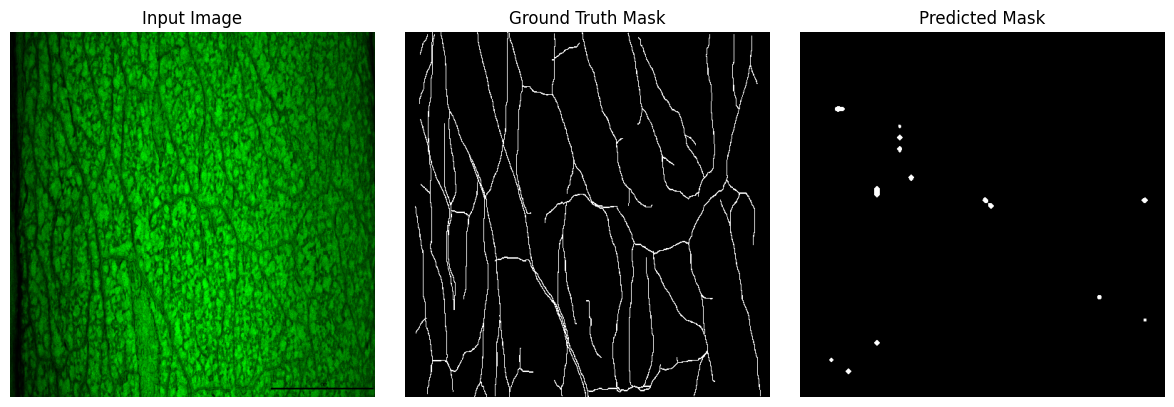

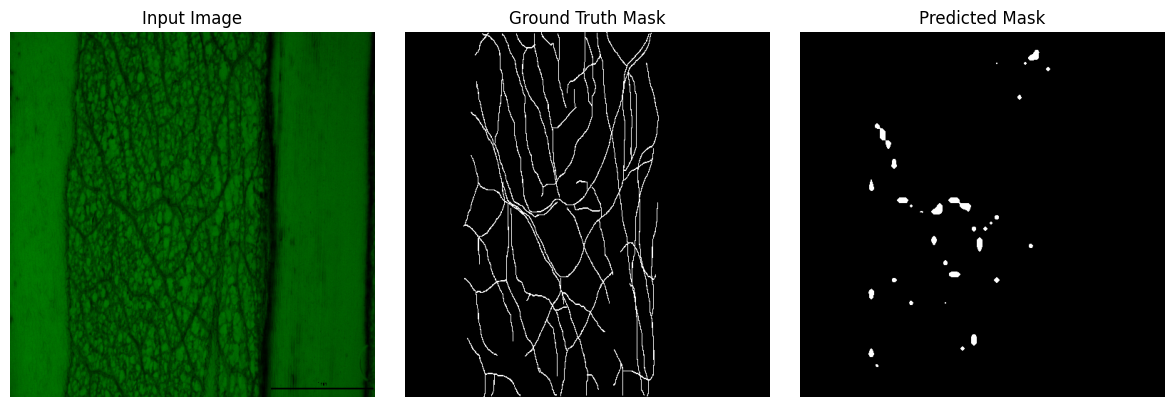

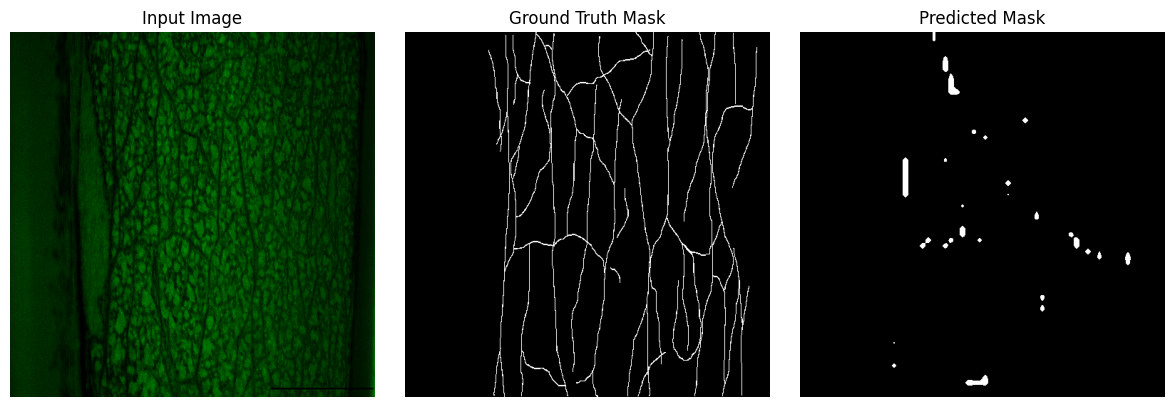

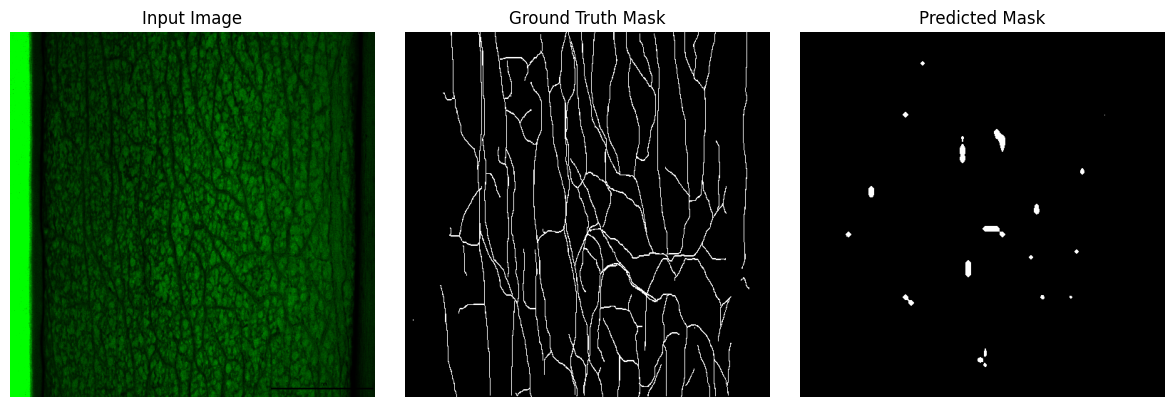

In [18]:
visualize_predictions(model, test_loader, num_samples=4)